## Overview

In this tutorial, we will explore the use of adversarial learning
([Goodfellow et al., 2014](https://arxiv.org/abs/1412.6572)) for image
classification using the Neural Structured Learning (NSL) framework.

The core idea of adversarial learning is to train a model with
adversarially-perturbed data (called adversarial examples) in addition to the
organic training data. The adversarial examples are constructed to intentionally
mislead the model into making wrong predictions or classifications. By training
with such examples, the model learns to be robust against adversarial
perturbation when making predictions.

In this tutorial, we illustrate the following procedure of applying adversarial
learning to obtain robust models using the Neural Structured Learning framework:

1.  Creata a neural network as a base model. In this tutorial, the base model is
    created with the `tf.keras` functional API; this procedure is compatible
    with models created by `tf.keras` sequential and subclassing APIs as well.
2.  Wrap the base model with the **`AdversarialRegularization`** wrapper class,
    which is provided by the NSL framework, to create a new `tf.keras.Model`
    instance. This new model will include the adversarial loss as a
    regularization term in its training objective.
3.  Convert examples in the training data to feature dictionaries.
4.  Train and evaluate the new model.

## Setup

Select TensorFlow 2.x to create an interactive development environment with
eager execution.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  !pip install --quiet tensorflow-gpu>=2.0.0

TensorFlow 2.x selected.


Install the Neural Structured Learning package.

In [0]:
!pip install --quiet neural-structured-learning

     |████████████████████████████████| 112kB 2.8MB/s 


Import libraries. We abbreviate `neural_structured_learning` to `nsl`.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Hyperparameters

We collect and explain the hyperparameters (in an `HParams` object) for model
training and evaluation.

Input/Output:

*   **`input_shape`**: The shape of the input tensor. Each image is 28-by-28
pixels with 1 channel.
*   **`num_classes`**: There are a total of 10 classes, corresponding to 10
digits [0-9].

Model architecture:

*   **`conv_filters`**: A list of numbers, each specifying the number of
filters in a convolutional layer.
*   **`kernel_size`**: The size of 2D convolution window, shared by all
convolutional layers.
*   **`pool_size`**: Factors to downscale the image in each max-pooling layer.
*   **`num_fc_units`**: The number of units (i.e., width) of each
fully-connected layer.

Training and evaluation:

*  **`batch_size`**: Batch size used for training and evaluation.
*  **`epochs`**: The number of training epochs.

Adversarial learning:

*   **`adv_multiplier`**: The weight of adversarial loss in the training
objective, relative to the labeled loss.
*   **`adv_step_size`**: The magnitude of adversarial perturbation.
*  **`adv_grad_norm`**: The norm to measure the magnitude of adversarial
perturbation.


In [0]:
class HParams(object):
  def __init__(self):
    self.input_shape = [300, 300, 3]
    self.num_classes = 3
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 20
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

## Rock Paper Scissor. image dataset

The [Rock-Paper-Scissor dataset](http://www.laurencemoroney.com/rock-paper-scissors-dataset/) contains color images
hands posed in Rock-Paper-Scissor. Each image is 300-by-300 pixels). The task involved is to classify images into
3 categories, one per image.

Here we load the Rock-Paper-Scissor dataset from
[TensorFlow Datasets](https://www.tensorflow.org/datasets). It handles
downloading the data and constructing a `tf.data.Dataset`. The loaded dataset
has two subsets:

*   `train` with 2,520 examples, and
*   `test` with 372 examples.

Examples in both subsets are stored in feature dictionaries with the following
two keys:

*   `image`: Array of pixel values, ranging from 0 to 255.
*   `label`: Groundtruth label, ranging from 0 to 3.

In [0]:
datasets = tfds.load('rock_paper_scissors')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/1.0.0. Subsequent calls will reuse this data.


To make the model numerically stable, we normalize the pixel values to [0, 1]
by mapping the dataset over the `normalize` function. After shuffling training
set and batching, we convert the examples to feature tuples `(image, label)`
for training the base model. We also provide a function to convert from tuples
to dictionaries for later use.

In [0]:
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

## Base model

Our base model will be a neural network consisting of 3 convolutional layers
follwed by 2 fully-connected layers (as defined in `HPARAMS`). Here we define
it using the Keras functional API. Feel free to try other APIs or model
architectures.

In [0]:
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [0]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0     

Next we train and evaluate the base model.

In [0]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/20
79/79 [==============================] - 28s 354ms/step - loss: 0.7322 - accuracy: 0.7837
Epoch 2/20
79/79 [==============================] - 22s 273ms/step - loss: 0.1288 - accuracy: 0.9770
Epoch 3/20
79/79 [==============================] - 21s 271ms/step - loss: 0.0128 - accuracy: 0.9988
Epoch 4/20
79/79 [==============================] - 22s 273ms/step - loss: 6.5132e-04 - accuracy: 1.0000
Epoch 5/20
79/79 [==============================] - 21s 269ms/step - loss: 1.1261e-04 - accuracy: 1.0000
Epoch 6/20
79/79 [==============================] - 21s 271ms/step - loss: 5.9790e-05 - accuracy: 1.0000
Epoch 7/20
79/79 [==============================] - 22s 273ms/step - loss: 4.3826e-05 - accuracy: 1.0000
Epoch 8/20
79/79 [==============================] - 21s 270ms/step - loss: 3.1401e-05 - accuracy: 1.0000
Epoch 9/20
79/79 [==============================] - 22s 273ms/step - loss: 2.6305e-05 - accuracy: 1.0000
Epoch 10/20
79/79 [==============================] - 21s 271ms/step

In [0]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('accuracy:', named_results['accuracy'])

12/12 [==============================] - 2s 146ms/step - loss: 2.5788 - accuracy: 0.6425
accuracy: 0.6424731


We can see that the base model achieves 64% accuracy on the test set. We will
see how robust it is in
[Robustness Under Adversarial Perturbations](#scrollTo=HXK9MGG8lBX3) below.

## Adversarial-regularized model

Here we show how to incorporate adversarial training into a Keras model with a
few lines of code, using the NSL framework. The base model is wrapped to create
a new `tf.Keras.Model`, whose training objective includes adversarial
regularization.

First, we create a config object with all relevant hyperparameters using the
helper function `nsl.configs.make_adv_reg_config`.

In [0]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

Now we can wrap a base model with `AdversarialRegularization`. Here we create a
new base model (`base_adv_model`), so that the existing one (`base_model`) can
be used in later comparison.

The returned `adv_model` is a `tf.keras.Model` object, whose training objective
includes a regularization term for the adversarial loss. To compute that loss,
the model has to have access to the label information (feature `label`), in
addition to regular input (feature `image`). For this reason, we convert the
examples in the datasets from tuples back to dictionaries. And we tell the
model which feature contains the label information via the `label_keys`
parameter.

In [0]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

Next we compile, train, and evaluate the adversarial-regularized model.

In [0]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/20
79/79 [==============================] - 37s 469ms/step - loss: 0.9927 - sparse_categorical_crossentropy: 0.6935 - sparse_categorical_accuracy: 0.7861 - adversarial_loss: 1.4958
Epoch 2/20
79/79 [==============================] - 36s 451ms/step - loss: 0.1802 - sparse_categorical_crossentropy: 0.0312 - sparse_categorical_accuracy: 0.9956 - adversarial_loss: 0.7379
Epoch 3/20
79/79 [==============================] - 36s 450ms/step - loss: 0.0373 - sparse_categorical_crossentropy: 0.0023 - sparse_categorical_accuracy: 1.0000 - adversarial_loss: 0.1748
Epoch 4/20
79/79 [==============================] - 36s 455ms/step - loss: 0.0084 - sparse_categorical_crossentropy: 6.5469e-04 - sparse_categorical_accuracy: 1.0000 - adversarial_loss: 0.0384
Epoch 5/20
79/79 [==============================] - 36s 453ms/step - loss: 2.1177e-04 - sparse_categorical_crossentropy: 1.6480e-04 - sparse_categorical_accuracy: 1.0000 - adversarial_loss: 2.3952e-04
Epoch 6/20
79/79 [=====================

In [0]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('accuracy:', named_results['sparse_categorical_accuracy'])

12/12 [==============================] - 3s 278ms/step - loss: 1.5449 - sparse_categorical_crossentropy: 1.4558 - sparse_categorical_accuracy: 0.7124 - adversarial_loss: 0.4456
accuracy: 0.71236557


We can see that the adversarial-regularized model also performs very well (71%
accuracy) on the test set.

## Robustness under Adversarial perturbations

Now we compare the base model and the adversarial-regularized model for
robustness under adversarial perturbation.

We will use the `AdversarialRegularization.perturb_on_batch` function for
generating adversarially perturbed examples. And we would like the generation
based on the base model. To do so, we wrap the base model with
`AdversarialRegularization`. Note that as long as we don't invoke training (`Model.fit`), the learned variables in the model won't change and the model is
still the same one as in section [Base Model](#scrollTo=JrrMpPNmpCKK).

In [0]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

We collect in a dictionary the models to be evaluted, and also create a metric
object for each of the models.

Note that we take `adv_model.base_model` in order to have the same input format
(not requiring label information) as the base model. The learned variables in
`adv_model.base_model` are the same as those in `adv_model`.

In [0]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

Here is the loop to generate perturbed examples and to evaluate models with
them. We save the perturbed images, labels, and predictions for visualization
in the next section.

In [0]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.067204
adv-regularized model accuracy: 0.755376


We can see that the accuracy of the base model drops dramatically (from 64% to
about 6.7%) when the input is perturbed adversarially. On the other hand, the
accuracy of the adversarial-regularized model only degrades a little (from 71%
to 75%). This demonstrates the effectiveness of adversarial learning on
improving model's robustness.

## Examples of adversarially-perturbed images

Here we take a look at the adversarially-perturbed images. We can see that the
perturbed images still show digits recognizable by human, but can successfully
fool the base model.

accuracy in batch 1:
base model: 3 / 32
adv-regularized model: 19 / 32


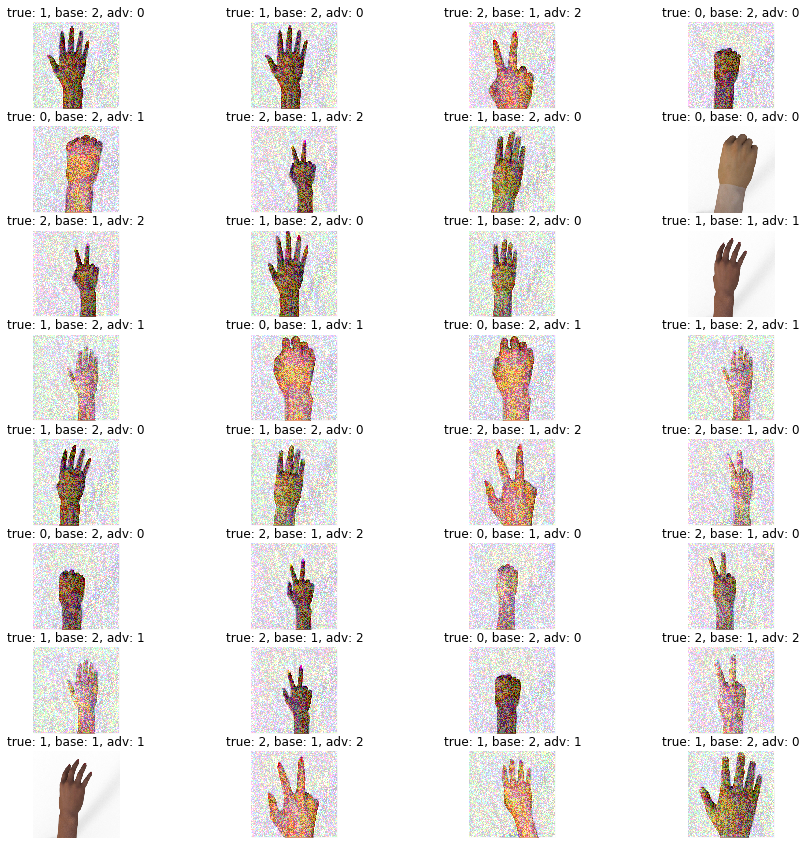

In [0]:
batch_index = 1

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()

accuracy in batch 10:
base model: 1 / 32
adv-regularized model: 24 / 32


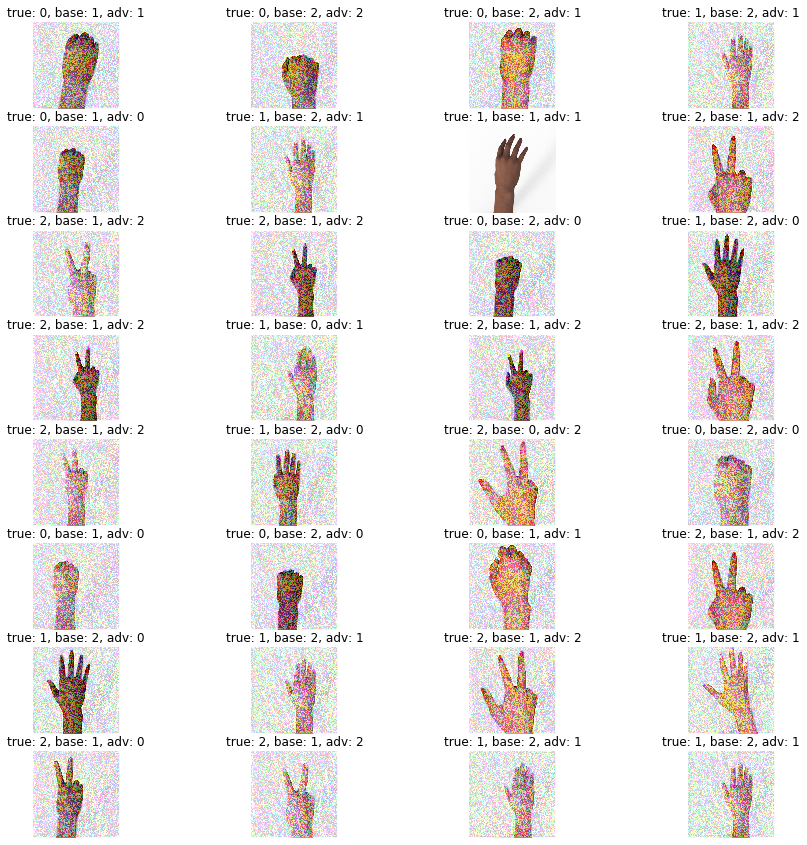

In [0]:
batch_index = 10

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()

## Conclusion

We have demonstrated the use of adversarial learning for image classification
using the Neural Structured Learning (NSL) framework. We encourage users to
experiment with different adversarial settings (in hyper-parameters) and to see
how they affect model robustness.

Referrence : https://www.tensorflow.org/neural_structured_learning/framework#step-by-step_tutorials